In [1]:
import numpy as np
import os
import pathlib
import tarfile
import mlutils

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import preprocessing

DATASET_URL = "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"
ANNOTATION_URL = "http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar"

def fetch_data(extract_dir = pathlib.Path().parent.resolve().joinpath("data")):
    image_dir = keras.utils.get_file('stanford_dogs_data', origin=DATASET_URL)
    anno_dir = keras.utils.get_file("stanford_dogs_annotation", origin=ANNOTATION_URL)

    image_extract = extract_dir.joinpath("Images")
    if not image_extract.is_dir():
        with tarfile.open(image_dir) as tar:
            tar.extractall(extract_dir)
    
    anno_extract = extract_dir.joinpath("Annotation")
    if not anno_extract.is_dir():
        with tarfile.open(anno_dir) as tar:
            tar.extractall(extract_dir)

    return image_extract, anno_extract

C:\Users\jens\main\learn\google_coral_ml\python\my_logs\run_29_06_2021_17-36-49


Fetch the data from http://vision.stanford.edu/aditya86/ImageNetDogs/

In [2]:
data_dir, anno_dir = fetch_data()
print(data_dir)
print(anno_dir)

C:\Users\jens\main\learn\google_coral_ml\python\packages\notebooks\dog_classifier\data\Images
C:\Users\jens\main\learn\google_coral_ml\python\packages\notebooks\dog_classifier\data\Annotation


There are 20580 different dog images

In [3]:
def len_iter(iter):
    return sum(1 for _ in iter)

image_count = len_iter(data_dir.glob('*/*.jpg'))
print(image_count)

20580


In [4]:
image_count_per_class = [len_iter(pathlib.Path(path).glob("*")) for path in data_dir.glob("*")]
print(image_count_per_class)
print(sum(image_count_per_class))

[152, 185, 252, 149, 214, 188, 196, 172, 172, 239, 175, 195, 187, 171, 159, 153, 157, 148, 151, 218, 182, 187, 188, 196, 151, 200, 232, 160, 155, 164, 182, 172, 179, 169, 172, 185, 164, 157, 197, 202, 202, 197, 196, 180, 182, 154, 157, 155, 158, 206, 183, 156, 169, 186, 152, 151, 150, 171, 167, 152, 154, 161, 155, 153, 152, 150, 159, 150, 159, 151, 150, 150, 154, 150, 150, 152, 153, 154, 169, 157, 153, 150, 150, 152, 152, 150, 184, 168, 218, 151, 202, 151, 156, 152, 159, 156, 170, 150, 178, 192, 150, 209, 200, 210, 195, 213, 218, 219, 196, 158, 153, 181, 155, 151, 155, 159, 155, 156, 150, 169]
20580


# Load data using `tf.keras.preprocessing`
[ref](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory?hl=en)

In [5]:
batch_size = 32
img_height = 300
img_width = 300

train_ds = preprocessing.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    validation_split=0.33,
    subset="training",
    seed=42,
    smart_resize=True,
    batch_size=batch_size,
    image_size=(img_height, img_width))

val_ds = preprocessing.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    validation_split=0.33,
    subset="validation",
    seed=42,
    smart_resize=True,
    batch_size=batch_size,
    image_size=(img_height, img_width))

Found 20580 files belonging to 120 classes.
Using 13789 files for training.
Found 20580 files belonging to 120 classes.
Using 6791 files for validation.


In [6]:
print(train_ds.element_spec)
print(train_ds.class_names[:10])

(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound']


In [7]:
short_class_names = np.array([name.split("-")[1] for name in train_ds.class_names])
print(short_class_names[:10])

['Chihuahua' 'Japanese_spaniel' 'Maltese_dog' 'Pekinese' 'Shih'
 'Blenheim_spaniel' 'papillon' 'toy_terrier' 'Rhodesian_ridgeback'
 'Afghan_hound']


In [8]:
# show first batch
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)
    print("The labels of this batch are ...")
    print(labels_batch.numpy())

(32, 300, 300, 3)
(32,)
The labels of this batch are ...
[ 25  22  70  36  12  51  30  67  74  76  55  31  59  11  40  80 100  36
  49   4  92  25   2  92  67  93  35  12 111  94  25  76]


# Load data using `tf.data` for finer control
[ref](https://www.tensorflow.org/tutorials/load_data/images#using_tfdata_for_finer_control)

In [9]:
def split_train_val(validation_split = 0.33):
    train_ds = None
    val_ds = None

    for i, path in enumerate(data_dir.glob("*")):
        path_ds = tf.data.Dataset.list_files(os.path.join(path, "*"), shuffle=False)
        path_ds = path_ds.shuffle(image_count_per_class[i], reshuffle_each_iteration=False)
        val_size = int(image_count_per_class[i] * validation_split)
        take = path_ds.take(val_size)
        skip = path_ds.skip(val_size)
        if i == 0:
            train_ds = skip
            val_ds = take
        else:
            train_ds = train_ds.concatenate(skip)
            val_ds = val_ds.concatenate(take)

    train_ds = train_ds.shuffle(train_ds.cardinality(), reshuffle_each_iteration=False)
    val_ds = val_ds.shuffle(val_ds.cardinality(), reshuffle_each_iteration=False)

    return train_ds, val_ds

train_ds, val_ds = split_train_val()

In [10]:
print(train_ds.cardinality().numpy())
print(val_ds.cardinality().numpy())
print()
for item in train_ds.take(5):
    print(item)

13846
6734

tf.Tensor(b'C:\\Users\\jens\\main\\learn\\google_coral_ml\\python\\packages\\notebooks\\dog_classifier\\data\\Images\\n02113023-Pembroke\\n02113023_4611.jpg', shape=(), dtype=string)
tf.Tensor(b'C:\\Users\\jens\\main\\learn\\google_coral_ml\\python\\packages\\notebooks\\dog_classifier\\data\\Images\\n02086079-Pekinese\\n02086079_10294.jpg', shape=(), dtype=string)
tf.Tensor(b'C:\\Users\\jens\\main\\learn\\google_coral_ml\\python\\packages\\notebooks\\dog_classifier\\data\\Images\\n02115913-dhole\\n02115913_3854.jpg', shape=(), dtype=string)
tf.Tensor(b'C:\\Users\\jens\\main\\learn\\google_coral_ml\\python\\packages\\notebooks\\dog_classifier\\data\\Images\\n02091831-Saluki\\n02091831_7957.jpg', shape=(), dtype=string)
tf.Tensor(b'C:\\Users\\jens\\main\\learn\\google_coral_ml\\python\\packages\\notebooks\\dog_classifier\\data\\Images\\n02108551-Tibetan_mastiff\\n02108551_175.jpg', shape=(), dtype=string)


In [11]:
class_names = np.array([item.name for item in data_dir.glob('*')])
print(class_names[:10])

['n02085620-Chihuahua' 'n02085782-Japanese_spaniel'
 'n02085936-Maltese_dog' 'n02086079-Pekinese' 'n02086240-Shih-Tzu'
 'n02086646-Blenheim_spaniel' 'n02086910-papillon' 'n02087046-toy_terrier'
 'n02087394-Rhodesian_ridgeback' 'n02088094-Afghan_hound']


In [12]:
from functools import partial

def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    # Integer encode the label
    return tf.argmax(one_hot)

def decode_img(img, smart_resize=True):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # resize the image to the desired size
    if smart_resize:
        return preprocessing.image.smart_resize(img, [img_height, img_width])
    else:
        return tf.image.resize(img, [img_height, img_width])

def process_path(smart_resize=True):
    def impl(file_path):
        label = get_label(file_path)
        # load the raw data from the file as a string
        img = tf.io.read_file(file_path)
        img = decode_img(img, smart_resize)
        return img, label
    # return the partial function definition
    return impl

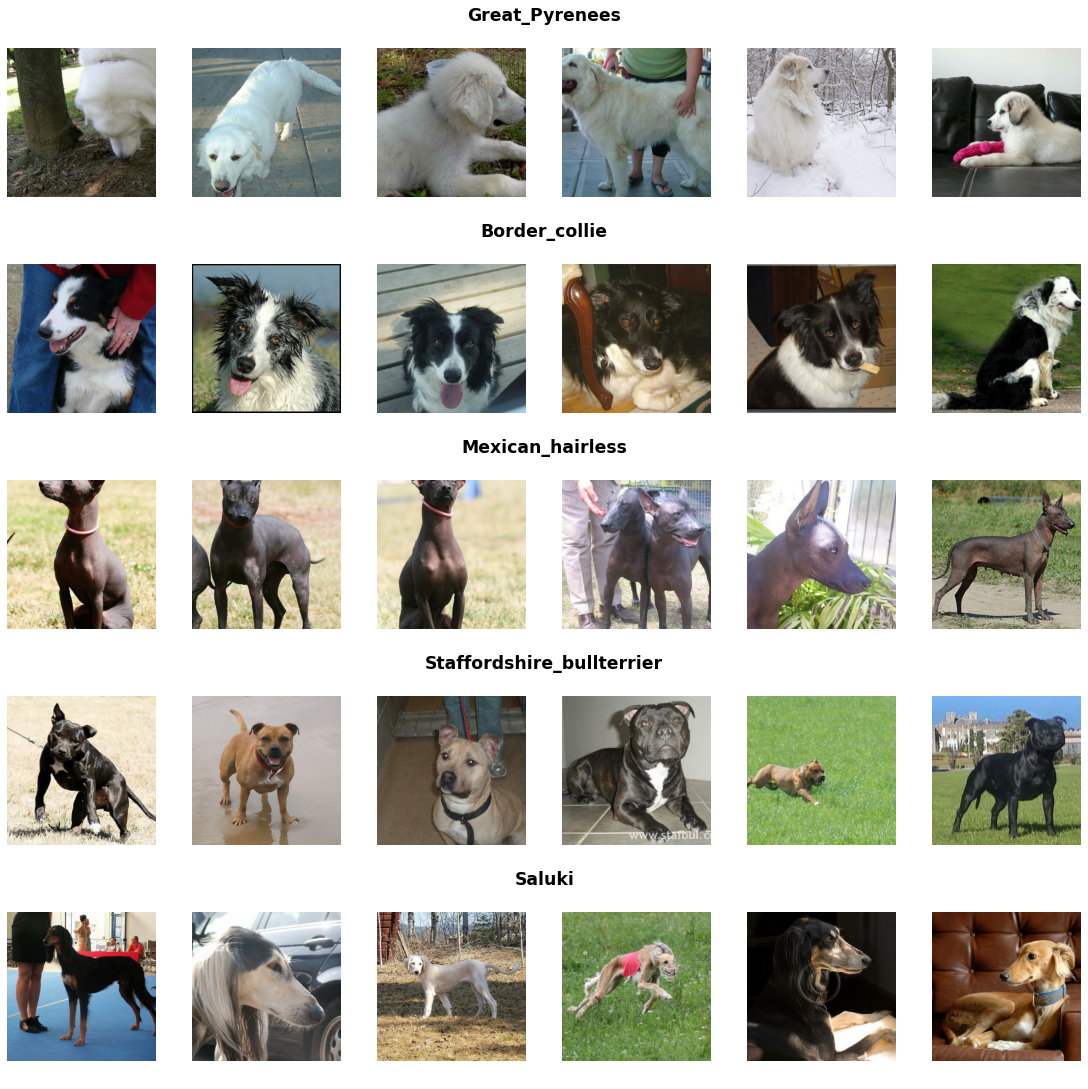

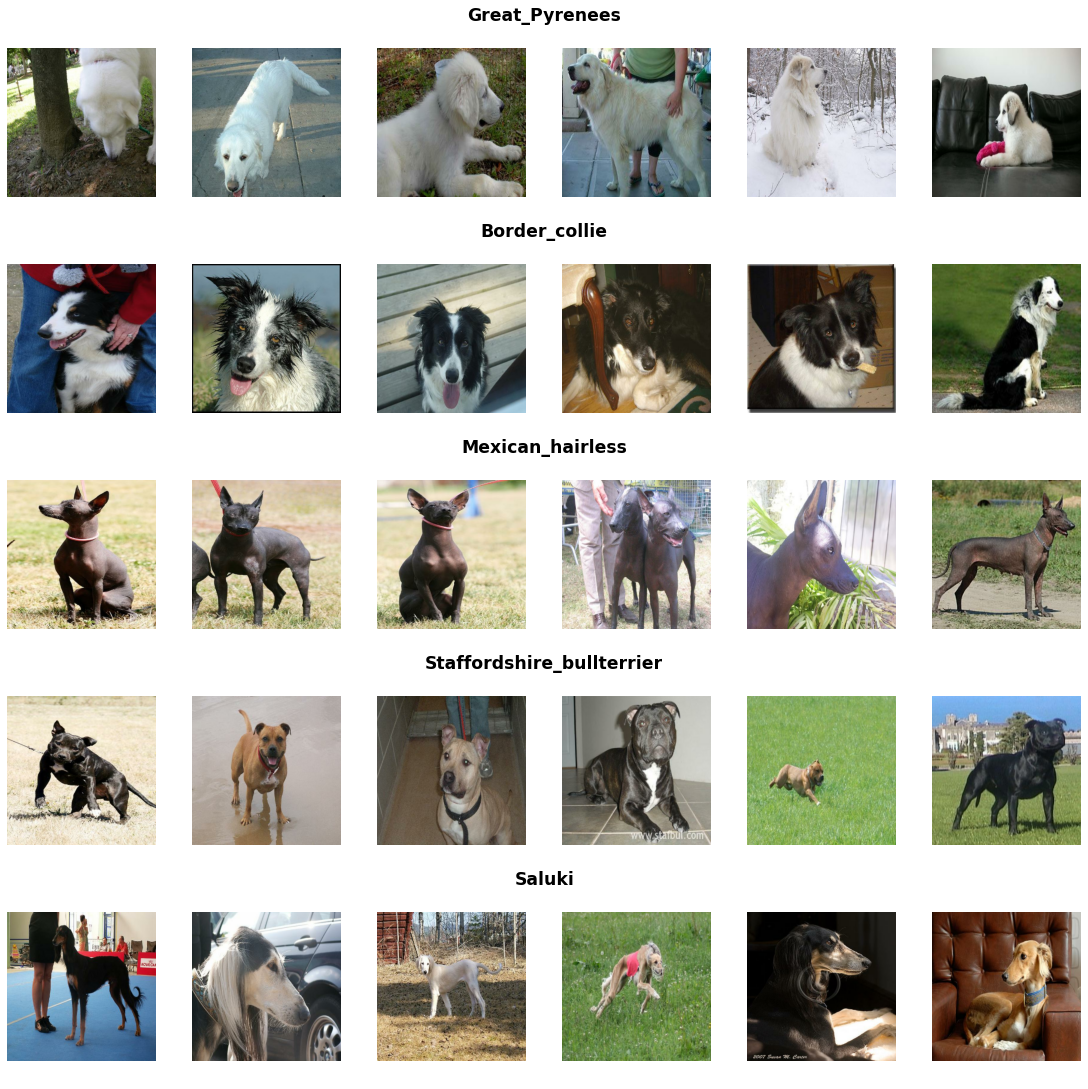

In [13]:
def plot_examples(smart_rezsize=True):
    path_ds = tf.data.Dataset.list_files(str(data_dir.joinpath("*")), seed=42)

    fig = plt.figure(figsize=[15, 15], constrained_layout=True)
    grid = gridspec.GridSpec(5, 6, figure=fig)
    class_names = []

    for row, path in enumerate(path_ds.take(5)):
        path = path.numpy().decode("utf-8")
        pattern = pathlib.Path(path).joinpath("*")
        image_path_ds = tf.data.Dataset.list_files(str(pattern), seed=42)

        for col, image_path in enumerate(image_path_ds.take(6)):
            path = image_path.numpy()
            img, label = process_path(smart_rezsize)(path)
            if col == 0:
                class_names.append(short_class_names[label]) 
            ax = fig.add_subplot(grid[row, col])
            ax.imshow(img.numpy().astype("uint8"))
            ax.axis("off")

    for row, name in enumerate(class_names):
        ax = fig.add_subplot(grid[row, :])
        ax.set_title(name, fontsize="xx-large", fontweight="semibold")
        ax.set_frame_on(False)
        ax.axis('off')

    plt.show()

plot_examples(True)
plot_examples(False)

In [14]:
from tensorflow.keras.applications.vgg16 import preprocess_input

train_ds = train_ds.map(process_path(True), num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(process_path(True), num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=tf.data.AUTOTUNE)

In [15]:
for image, label in train_ds.take(3):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    print("-------")

Image shape:  (300, 300, 3)
Label:  111
-------
Image shape:  (300, 300, 3)
Label:  3
-------
Image shape:  (300, 300, 3)
Label:  118
-------


In [16]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds

In [17]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

---

In [18]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model

vgg16 = VGG16(include_top=False, weights="imagenet", input_shape=(img_height, img_width, 3))
vgg16.layers

In [19]:
for layer in vgg16.layers:
    layer.trainable = False

In [20]:
def build_model(base_model, n_units = 1024, lr = 0.0002):
    headModel = base_model.output
    headModel = layers.Flatten(name="flatten")(headModel)
    headModel = layers.Dense(n_units, activation="relu")(headModel)
    headModel = layers.Dropout(0.5)(headModel)
    headModel = layers.Dense(len(class_names))(headModel)
    model = Model(inputs=base_model.input, outputs=headModel)

    loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    opt = keras.optimizers.SGD(learning_rate=lr)

    model.compile(optimizer=opt, loss=loss_fn, metrics=['accuracy'])

    return model

model = build_model(vgg16)


In [21]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0     

In [22]:
epochs = 50
tensorboard_cb = keras.callbacks.TensorBoard(mlutils.get_run_logdir())
early_stopping_cb = keras.callbacks.EarlyStopping(
  monitor="loss",
  mode="min",
  patience=3,
  min_delta=0.02,
  verbose=1,
  restore_best_weights=True)

history = model.fit(train_ds, epochs=epochs, callbacks=[tensorboard_cb, early_stopping_cb])

Epoch 1/50


KeyboardInterrupt: 

In [89]:
model.evaluate(val_ds)

211/211 [==============================] - 34s 153ms/step - loss: 4.5248 - accuracy: 0.1077


[4.524840831756592, 0.1076626107096672]

In [88]:
batch_new = next(iter(val_ds))
X_new = batch_new[0]
y_new = batch_new[1]
print(X_new.shape)
print(y_new.shape)
print()
print("Predictions using original model and 'tf.nn.softmax'")
print("-----------------------------------")
pred = model.predict(X_new)
pred = tf.nn.softmax(pred, axis=1).numpy()
print(np.argmax(pred, axis=1))
print()
print("Predictions model with softmax layer model")
print("-----------------------------------")
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax(axis=1)])
pred = probability_model.predict(X_new)
print(np.argmax(pred, axis=1))
print()
print("Grounding Truth (labels)")
print("-----------------------------------")
print(y_new.numpy())

(32, 300, 300, 3)
(32,)

Predictions using original model and 'tf.nn.softmax'
-----------------------------------
[ 64  53  14 100  66  13  88  69  95  21 106  48   1 119  77  94 106 114
  50 119   4  86  91  44  19  18  27  24  96  81  64  90]

Predictions model with softmax layer model
-----------------------------------
[ 64  53  14 100  66  13  88  69  95  21 106  48   1 119  77  94 106 114
  50 119   4  86  91  44  19  18  27  24  96  81  64  90]

Grounding Truth (labels)
-----------------------------------
[ 63   4  10  29  64  72  56  95  12  58  71  73  97  91  46  57  15  26
  50 102  50  78  11  66  38  43  95 101  91   9  66  25]
